In [6]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
from pathlib import Path

# Import our custom modules
from utils.feature_extraction import FeatureExtractionNetwork, PhaseCorrelationTensorComputation, ImagePreprocessor
from utils.manifold_learning import ManifoldLearningModule
# Import our new tiny topological analysis instead of the original one
from utils.topological_small import TinyTopologicalFeatureExtraction
from utils.classification import ClassificationNetwork

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create directories
os.makedirs('data', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

Using device: cuda


In [7]:
# Custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, image_files, labels):
        self.image_files = image_files
        self.labels = labels
        
        # Define transforms using standard torchvision transformations
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        label = self.labels[idx]
        
        try:
            # Open image with PIL and convert to RGB
            with Image.open(image_path) as img:
                img = img.convert('RGB')
                img_tensor = self.transform(img)
                return img_tensor, label
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return a placeholder tensor and the label
            return torch.ones(3, 256, 256), label

CSV columns: ['Unnamed: 0', 'file_name', 'label']
First few rows of the CSV:
   Unnamed: 0                                        file_name  label
0           0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1           1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2           2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3           3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4           4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1
Total images found: 79950
Natural images: 39975
AI-generated images: 39975
Batch shape: torch.Size([2, 3, 256, 256])
Labels: tensor([0, 1])


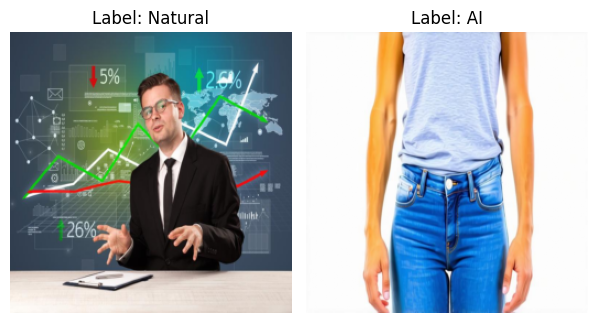

In [8]:
# Load dataset from train.csv file
import pandas as pd

# Path to the CSV file
csv_path = r'images\ai_vs_human_generated_dataset\train.csv'

# Read the CSV file
df = pd.read_csv(csv_path)
print(f"CSV columns: {df.columns.tolist()}")
print(f"First few rows of the CSV:\n{df.head()}")

# Get the base path for the images
base_path = os.path.dirname(csv_path)

# Parse file paths and labels from CSV
all_files = []
labels = []

# Extract file paths and labels from the DataFrame
for index, row in df.iterrows():
    file_path = os.path.join(base_path, row['file_name'])
    label = int(row['label'])  # Assuming 0 = Natural, 1 = AI
    
    # Verify that the file exists
    if os.path.exists(file_path):
        all_files.append(file_path)
        labels.append(label)
    else:
        print(f"Warning: File not found: {file_path}")

print(f"Total images found: {len(all_files)}")
print(f"Natural images: {labels.count(0)}")
print(f"AI-generated images: {labels.count(1)}")

# Create the dataset
dataset = CustomImageDataset(all_files, labels)

# Split the dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders with smaller batch size
batch_size = 2  # Reduced from 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Check a batch of data
try:
    images, labels = next(iter(train_loader))
    print(f"Batch shape: {images.shape}")
    print(f"Labels: {labels}")
    
    # Visualize a few images
    plt.figure(figsize=(12, 6))
    for i in range(min(4, len(images))):
        plt.subplot(1, 4, i+1)
        img = images[i].permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title(f"Label: {'Natural' if labels[i] == 0 else 'AI'}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error loading batch: {e}")
    print("This might indicate issues with image loading or dataset structure.")

In [ ]:
# Initialize model components
feature_network = FeatureExtractionNetwork().to(device)
tensor_computer = PhaseCorrelationTensorComputation().to(device)
manifold_module = ManifoldLearningModule().to(device)

# For topological analysis, we need to create point clouds from manifold features
# This is a simplified version for training
class PointCloudGenerator(nn.Module):
    def __init__(self, num_points=50, noise_scale=0.1):  # Reduced from 100 to 50 points
        super().__init__()
        self.num_points = num_points
        self.noise_scale = noise_scale
    
    def forward(self, features):
        batch_size, feature_dim = features.size()
        
        # Expand features to create a point cloud
        point_cloud = features.unsqueeze(1).expand(-1, self.num_points, -1)
        
        # Add noise for a more interesting point cloud
        noise = torch.randn(batch_size, self.num_points, feature_dim, device=features.device) * self.noise_scale
        point_cloud = point_cloud + noise
        
        return point_cloud

point_cloud_generator = PointCloudGenerator().to(device)

# Use our new TinyTopologicalFeatureExtraction instead of the original one
topo_module = TinyTopologicalFeatureExtraction(
    input_dim=32,           # Input feature dimension
    hidden_dim=32,          # Reduced hidden dimension
    output_dim=16,          # Reduced output dimension
    max_edge_length=2.0,    # Maximum edge length for filtration
    num_filtrations=20,     # Reduced number of filtration values
    max_dimension=1         # Only dimension 0 for maximum efficiency
).to(device)

# Adjust classifier to work with the reduced dimension from topo_module
classifier = ClassificationNetwork(
    topo_dim=16,  # Match the reduced output dimension from TinyTopologicalFeatureExtraction
).to(device)

# Print model sizes
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Feature Extraction Network: {count_parameters(feature_network):,} parameters")
print(f"Phase Correlation Tensor Computation: {count_parameters(tensor_computer):,} parameters")
print(f"Manifold Learning Module: {count_parameters(manifold_module):,} parameters")
print(f"Tiny Topological Feature Extraction: {count_parameters(topo_module):,} parameters")  # Should be much smaller now
print(f"Classification Network: {count_parameters(classifier):,} parameters")
print(f"Total: {count_parameters(feature_network) + count_parameters(tensor_computer) + count_parameters(manifold_module) + count_parameters(topo_module) + count_parameters(classifier):,} parameters")

Feature Extraction Network: 12,295,787 parameters
Phase Correlation Tensor Computation: 441,345 parameters
Manifold Learning Module: 1,479,040 parameters
Tiny Topological Feature Extraction: 448 parameters
Classification Network: 123,399 parameters
Total: 14,340,019 parameters


In [10]:
# Define loss functions
classification_criterion = nn.CrossEntropyLoss()

# VAE loss for manifold learning
def vae_loss(x_recon, x, mu, logvar, beta=1.0):
    # Reconstruction loss
    recon_loss = F.mse_loss(x_recon, x, reduction='sum') / x.size(0)
    
    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    
    return recon_loss + beta * kl_loss

# Define optimizers
# We'll use separate optimizers for each component
feature_optimizer = optim.Adam(list(feature_network.parameters()) + 
                              list(tensor_computer.parameters()), lr=1e-4)
manifold_optimizer = optim.Adam(manifold_module.parameters(), lr=1e-4)
topo_optimizer = optim.Adam(topo_module.parameters(), lr=1e-4)
classifier_optimizer = optim.Adam(classifier.parameters(), lr=1e-4)

# Learning rate schedulers
feature_scheduler = optim.lr_scheduler.ReduceLROnPlateau(feature_optimizer, mode='min', factor=0.5, patience=5)
manifold_scheduler = optim.lr_scheduler.ReduceLROnPlateau(manifold_optimizer, mode='min', factor=0.5, patience=5)
topo_scheduler = optim.lr_scheduler.ReduceLROnPlateau(topo_optimizer, mode='min', factor=0.5, patience=5)
classifier_scheduler = optim.lr_scheduler.ReduceLROnPlateau(classifier_optimizer, mode='min', factor=0.5, patience=5)

In [7]:
# 1. Reduce batch size
batch_size = 2  # Change this in your DataLoader creation

# 2. Use gradient accumulation
gradient_accumulation_steps = 2

# Modify the train_epoch function to use gradient accumulation
def train_epoch_with_accumulation(train_loader, epoch, accumulation_steps=2):
    # Set models to training mode
    feature_network.train()
    tensor_computer.train()
    manifold_module.train()
    topo_module.train()
    classifier.train()
    
    # Initialize metrics
    total_loss = 0
    total_feature_loss = 0
    total_manifold_loss = 0
    total_topo_loss = 0
    total_classifier_loss = 0
    correct = 0
    total = 0
    
    # Training loop
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}")
    
    # Zero gradients at the start
    feature_optimizer.zero_grad()
    manifold_optimizer.zero_grad()
    topo_optimizer.zero_grad()
    classifier_optimizer.zero_grad()
    
    for batch_idx, (images, labels) in enumerate(progress_bar):
        # Move data to device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass through feature extraction
        features, _ = feature_network(images)
        phase_tensor = tensor_computer(features)
        
        # Forward pass through manifold learning
        manifold_features, (mu, logvar, z) = manifold_module(phase_tensor)
        
        # Reconstruct for VAE loss
        recon_tensor = manifold_module.decode(z)
        manifold_loss = manifold_module.get_loss(phase_tensor, recon_tensor, mu, logvar)[0]
        
        # Generate point cloud for topological analysis
        point_cloud = point_cloud_generator(manifold_features)
        
        # Forward pass through topological analysis - now using TinyTopologicalFeatureExtraction
        topo_features, _ = topo_module(point_cloud)
        
        # Forward pass through classifier
        logits, probs, uncertainty = classifier(manifold_features, topo_features)
        
        # Compute losses
        classifier_loss = classification_criterion(logits, labels)
        feature_loss = F.mse_loss(features, features.detach())  # Dummy loss for feature extraction
        topo_loss = F.mse_loss(topo_features, topo_features.detach())  # Dummy loss for topological analysis
        
        # Scale losses by accumulation steps
        feature_loss = feature_loss / accumulation_steps
        manifold_loss = manifold_loss / accumulation_steps
        topo_loss = topo_loss / accumulation_steps
        classifier_loss = classifier_loss / accumulation_steps
        
        # Backward pass - with retain_graph
        feature_loss.backward(retain_graph=True)
        manifold_loss.backward(retain_graph=True)
        topo_loss.backward(retain_graph=True)
        classifier_loss.backward()
        
        # Update metrics
        total_feature_loss += feature_loss.item() * accumulation_steps
        total_manifold_loss += manifold_loss.item() * accumulation_steps
        total_topo_loss += topo_loss.item() * accumulation_steps
        total_classifier_loss += classifier_loss.item() * accumulation_steps
        total_loss += (feature_loss.item() + manifold_loss.item() + 
                      topo_loss.item() + classifier_loss.item()) * accumulation_steps
        
        # Calculate accuracy
        pred = logits.argmax(dim=1)
        correct += pred.eq(labels).sum().item()
        total += labels.size(0)
        
        # Only step optimizers after accumulation_steps
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
            feature_optimizer.step()
            manifold_optimizer.step()
            topo_optimizer.step()
            classifier_optimizer.step()
            
            # Zero gradients
            feature_optimizer.zero_grad()
            manifold_optimizer.zero_grad()
            topo_optimizer.zero_grad()
            classifier_optimizer.zero_grad()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': total_loss / (batch_idx + 1),
            'acc': 100. * correct / total
        })
    
    # Calculate epoch metrics
    avg_loss = total_loss / len(train_loader)
    avg_feature_loss = total_feature_loss / len(train_loader)
    avg_manifold_loss = total_manifold_loss / len(train_loader)
    avg_topo_loss = total_topo_loss / len(train_loader)
    avg_classifier_loss = total_classifier_loss / len(train_loader)
    accuracy = 100. * correct / total
    
    return {
        'loss': avg_loss,
        'feature_loss': avg_feature_loss,
        'manifold_loss': avg_manifold_loss,
        'topo_loss': avg_topo_loss,
        'classifier_loss': avg_classifier_loss,
        'accuracy': accuracy
    }

In [8]:
def validate(val_loader):
    # Set models to evaluation mode
    feature_network.eval()
    tensor_computer.eval()
    manifold_module.eval()
    topo_module.eval()
    classifier.eval()
    
    # Initialize metrics
    val_loss = 0
    correct = 0
    total = 0
    
    # Store predictions and true labels for confusion matrix
    all_preds = []
    all_labels = []
    all_probs = []
    all_uncertainty = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            features, _ = feature_network(images)
            phase_tensor = tensor_computer(features)
            manifold_features, _ = manifold_module(phase_tensor)
            point_cloud = point_cloud_generator(manifold_features)
            
            # Forward pass through topological analysis - using TinyTopologicalFeatureExtraction
            topo_features, _ = topo_module(point_cloud)
            
            # Forward pass through classifier
            logits, probs, uncertainty = classifier(manifold_features, topo_features)
            
            # Compute loss
            loss = classification_criterion(logits, labels)
            val_loss += loss.item()
            
            # Calculate accuracy
            pred = logits.argmax(dim=1)
            correct += pred.eq(labels).sum().item()
            total += labels.size(0)
            
            # Store for metrics
            all_preds.append(pred.cpu())
            all_labels.append(labels.cpu())
            all_probs.append(probs.cpu())
            all_uncertainty.append(uncertainty.cpu())
    
    # Calculate metrics
    avg_loss = val_loss / len(val_loader)
    accuracy = 100. * correct / total
    
    # Concatenate predictions and labels
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    all_probs = torch.cat(all_probs)
    all_uncertainty = torch.cat(all_uncertainty)
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs,
        'uncertainty': all_uncertainty
    }

In [ ]:
# Training parameters
num_epochs = 10
gradient_accumulation_steps = 2
best_val_accuracy = 0

# Metrics tracking
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(1, num_epochs + 1):
    # Train for one epoch using gradient accumulation
    train_metrics = train_epoch_with_accumulation(train_loader, epoch, accumulation_steps=gradient_accumulation_steps)
    train_losses.append(train_metrics['loss'])
    train_accuracies.append(train_metrics['accuracy'])
    
    # Validate
    val_metrics = validate(val_loader)
    val_losses.append(val_metrics['loss'])
    val_accuracies.append(val_metrics['accuracy'])
    
    # Print metrics
    print(f"Epoch {epoch}/{num_epochs}:")
    print(f"  Train Loss: {train_metrics['loss']:.4f}, Train Acc: {train_metrics['accuracy']:.2f}%")
    print(f"  Val Loss: {val_metrics['loss']:.4f}, Val Acc: {val_metrics['accuracy']:.2f}%")
    
    # Update learning rate schedulers
    feature_scheduler.step(val_metrics['loss'])
    manifold_scheduler.step(val_metrics['loss'])
    topo_scheduler.step(val_metrics['loss'])
    classifier_scheduler.step(val_metrics['loss'])
    
    # Save best model
    if val_metrics['accuracy'] > best_val_accuracy:
        best_val_accuracy = val_metrics['accuracy']
        print(f"  New best model with accuracy: {best_val_accuracy:.2f}%")
        
        # Save each component separately
        torch.save(feature_network.state_dict(), 'models/feature_network.pth')
        torch.save(tensor_computer.state_dict(), 'models/tensor_computer.pth')
        torch.save(manifold_module.state_dict(), 'models/manifold_module.pth')
        torch.save(topo_module.state_dict(), 'models/tiny_topo_module.pth')  # Changed name to reflect the new module
        torch.save(classifier.state_dict(), 'models/classifier.pth')

print("Training complete!")
print(f"Best validation accuracy: {best_val_accuracy:.2f}%")

Epoch 1:   0%|          | 0/31980 [00:00<?, ?it/s]

DEBUG - Input shape: torch.Size([2, 128, 8, 8])
DEBUG - After first conv: torch.Size([2, 256, 4, 4])
DEBUG - After second conv: torch.Size([2, 256, 2, 2])
DEBUG - After third conv: torch.Size([2, 256, 1, 1])
DEBUG - After flatten: torch.Size([2, 256])
DEBUG - Creating FC layers with input dim: 256
DEBUG - x3 shape before flatten: torch.Size([2, 256, 1, 1])
DEBUG - Latent z shape: torch.Size([2, 32])
DEBUG - After fc_decoder: torch.Size([2, 256])
DEBUG - After unflatten: torch.Size([2, 256, 1, 1])
DEBUG - Final reconstruction: torch.Size([2, 128, 8, 8])
DEBUG - Input shape: torch.Size([2, 128, 8, 8])
DEBUG - After first conv: torch.Size([2, 256, 4, 4])
DEBUG - After second conv: torch.Size([2, 256, 2, 2])
DEBUG - After third conv: torch.Size([2, 256, 1, 1])
DEBUG - After flatten: torch.Size([2, 256])
DEBUG - Latent z shape: torch.Size([2, 32])
DEBUG - After fc_decoder: torch.Size([2, 256])
DEBUG - After unflatten: torch.Size([2, 256, 1, 1])
DEBUG - Final reconstruction: torch.Size([2, 1